# Dataset Description

### 学生画像——属性设计

| Attribute      | Description                                                  | 备注                            |
| -------------- | ------------------------------------------------------------ | ------------------------------- |
| student_id            | student's id           | 主键，不携带预测信息                            |
| ts/mobile/nickname            | timestamp etc.          | 不携带预测信息                            |
| sex            | student's sex (binary: 'girl' or 'boy')           | 性别                            |
| birthday            | student's birthday (belike: 2018-01-01)                        | 需要处理为数值形式的年龄                            |
| city           | student's city ~~(numeric: from 1 to 4)~~ **(numeric: from 1 to 100)** | 学生所在城市（目前缺失）                            |
| cat            | CAT grade:<br />cat_listening_level、cat_reading_level、cat_oral_level                            | CAT 评级                        |
| last_1/2/3 | 包含4个属性：<br />当前课程是否有效 last_n_valid（binary: '0' - invalid or '1' - valid）、<br />拼读成绩 last_n_spell_score、游戏成绩 last_n_game_score(float: from 0 to 100) | 过去倒数第1～3节课的信息        |
| lesson_id | current lesson (numeric: from 0 to 1000)                     | 当前是第几节课                  |
|                |                                                              |                                 |
| (last_0) | 包含3个属性：<br />拼读成绩 spell_score、游戏成绩 game_score(float: from 0 to 100) | 当前课堂表现——回归预测的目标变量 |

# Import Necessary Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from math import sqrt
from IPython.display import display  # 新增：用于更友好的表格显示
%matplotlib inline

# Data Loading

In [4]:
import pandas as pd
from IPython.display import display  # 新增：用于更友好的表格显示

# 加载数据集
# 09.24
data_path = "datasets/student-por_aixue_0924.parquet"
df = pd.read_parquet(data_path)
# 08.29
data_path_0829 = "datasets/student-por_aixue_0829.parquet"
df_0829 = pd.read_parquet(data_path_0829)
# 08.15
data_path_0815 = "datasets/student-por_aixue_0815.parquet"
df_0815 = pd.read_parquet(data_path_0815)

print("📔 Data Shape: number of Rows = {0}, number of Columns = {1}".format(df.shape[0],df.shape[1]))

# 打印前5行并显示所有列
with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Shape: number of Rows = 1567, number of Columns = 19
📔 Data Examples: 


,student_id,lesson_id,city_id,ts,spell_score,game_score,last_1_spell_score,last_1_game_score,last_2_spell_score,last_2_game_score,last_3_spell_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level
0,5611.0,1.0,一线,1.755588e+09,19.750000,26.923077,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
1,5611.0,2.0,None,1.755016e+09,32.000000,57.142857,19.750000,26.923077,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
2,5611.0,3.0,一线,1.754564e+09,39.029412,91.666667,32.000000,57.142857,19.750000,26.923077,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
3,5611.0,5.0,None,1.757497e+09,0.000000,0.000000,39.029412,91.666667,32.000000,57.142857,19.75,26.923077,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
4,5611.0,9.0,一线,1.758365e+09,0.000000,0.000000,0.000000,0.000000,39.029412,91.666667,32.00,57.142857,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0


In [5]:
# 统计学生数量，即有多少不同的student_id
student_count = df['student_id'].nunique()
print(f"📔 今日 学生总数: {student_count}；上课数据总数: {df.shape[0]}")

student_count_0829 = df_0829['student_id'].nunique()
print(f"📔 08.29 学生总数: {student_count_0829}；上课数据总数: {df_0829.shape[0]}")

student_count_0815 = df_0815['student_id'].nunique()
print(f"📔 08.15 学生总数: {student_count_0815}；上课数据总数: {df_0815.shape[0]}")

📔 今日 学生总数: 739；上课数据总数: 1567
📔 08.29 学生总数: 204；上课数据总数: 492
📔 08.15 学生总数: 107；上课数据总数: 159


In [6]:
print("📔 Data Info:")
df.info()

📔 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   student_id           1567 non-null   float64
 1   lesson_id            1567 non-null   float64
 2   city_id              1099 non-null   object 
 3   ts                   1567 non-null   float64
 4   spell_score          1567 non-null   float64
 5   game_score           1567 non-null   float64
 6   last_1_spell_score   828 non-null    float64
 7   last_1_game_score    828 non-null    float64
 8   last_2_spell_score   616 non-null    float64
 9   last_2_game_score    616 non-null    float64
 10  last_3_spell_score   493 non-null    float64
 11  last_3_game_score    493 non-null    float64
 12  mobile               1567 non-null   int64  
 13  nickname             1567 non-null   object 
 14  sex                  1567 non-null   object 
 15  birthday             676 

In [7]:
print("📔 Show Statical Descriptopn of numerical columns")
df.describe().T

📔 Show Statical Descriptopn of numerical columns


,count,mean,std,min,25%,50%,75%,max
student_id,1567.0,4.288443e+04,7.734512e+03,1.000000e+01,4.252300e+04,4.488000e+04,4.637550e+04,4.704600e+04
lesson_id,1567.0,1.064837e+01,1.442458e+01,1.000000e+00,1.000000e+00,3.000000e+00,1.700000e+01,2.310000e+02
ts,1567.0,1.756971e+09,1.171230e+06,1.754564e+09,1.756019e+09,1.757163e+09,1.757855e+09,1.758639e+09
spell_score,1567.0,5.058907e+01,2.786464e+01,0.000000e+00,3.584242e+01,5.733333e+01,7.132738e+01,9.916667e+01
game_score,1567.0,4.907977e+01,4.157154e+01,0.000000e+00,0.000000e+00,6.000000e+01,8.928571e+01,1.000000e+02
last_1_spell_score,828.0,5.506192e+01,2.467987e+01,0.000000e+00,4.315981e+01,6.051458e+01,7.294000e+01,9.916667e+01
last_1_game_score,828.0,4.599489e+01,4.185329e+01,0.000000e+00,0.000000e+00,5.454545e+01,8.828231e+01,1.000000e+02
last_2_spell_score,616.0,5.441330e+01,2.487422e+01,0.000000e+00,4.271094e+01,6.018860e+01,7.202885e+01,9.800000e+01
last_2_game_score,616.0,3.999346e+01,4.169505e+01,0.000000e+00,0.000000e+00,3.333333e+01,8.571429e+01,1.000000e+02
last_3_spell_score,493.0,5.365525e+01,2.519084e+01,0.000000e+00,4.061111e+01,5.960000e+01,7.188889e+01,9.800000e+01


# Data Recovery

解决：city字段提取失败

In [8]:
print("📔 开始城市等级填充处理...")

# 1. 遍历df（忽略city_id为空的数据），构建字典key为student_id，value为city_id

# 过滤出city_id不为空的数据
valid_city_data = df[df['city_id'].notna() & (df['city_id'] != '')]

print("city_id所有值如下：")
print(df['city_id'].unique())

# 构建student_id到city_id的映射字典
# 使用groupby确保每个学生只取一个城市等级（如果有多个，取第一个）
student_city_mapping = valid_city_data.groupby('student_id')['city_id'].first().to_dict()

# 2. 将df中city_id为空的数据，使用字典中的city_id填充

# 创建city_id的副本用于填充
df['city_id_filled'] = df['city_id'].copy()

# 填充逻辑：如果city_id为空/NaN/空值，则用字典中的值填充
def fill_city_id(row):
    city_id = row['city_id']
    student_id = row['student_id']
    
    # 如果city_id为空/NaN/空值，尝试用字典填充
    if pd.isna(city_id) or city_id == '':
        if student_id in student_city_mapping:
            return student_city_mapping[student_id]
        else:
            return '空值'  # 如果字典中也没有，保持为空值
    else:
        return city_id  # 如果已有值，保持不变

# 应用填充逻辑
df['city_id_filled'] = df.apply(fill_city_id, axis=1)

# 3. 统计city_id为空的数据个数

print(f"\n📊 填充后的城市等级分布:")
city_distribution_after = df['city_id_filled'].value_counts()
print(city_distribution_after)

# 将填充后的结果替换原列
df['city_id'] = df['city_id_filled']
df = df.drop('city_id_filled', axis=1)  # 删除临时列

print(f"\n✅ 城市等级填充完成！")

📔 开始城市等级填充处理...
city_id所有值如下：
['一线' None '二线' '三线' '四线' '新一线' '']

📊 填充后的城市等级分布:
city_id_filled
三线     301
一线     295
空值     258
二线     255
新一线    237
四线     221
Name: count, dtype: int64

✅ 城市等级填充完成！


In [9]:
print("📔 Data Info: ")
df.info()

📔 Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   student_id           1567 non-null   float64
 1   lesson_id            1567 non-null   float64
 2   city_id              1567 non-null   object 
 3   ts                   1567 non-null   float64
 4   spell_score          1567 non-null   float64
 5   game_score           1567 non-null   float64
 6   last_1_spell_score   828 non-null    float64
 7   last_1_game_score    828 non-null    float64
 8   last_2_spell_score   616 non-null    float64
 9   last_2_game_score    616 non-null    float64
 10  last_3_spell_score   493 non-null    float64
 11  last_3_game_score    493 non-null    float64
 12  mobile               1567 non-null   int64  
 13  nickname             1567 non-null   object 
 14  sex                  1567 non-null   object 
 15  birthday             676

# Data Statistics

In [10]:
# 打印前5行并显示所有列
with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Examples: 


,student_id,lesson_id,city_id,ts,spell_score,game_score,last_1_spell_score,last_1_game_score,last_2_spell_score,last_2_game_score,last_3_spell_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level
0,5611.0,1.0,一线,1.755588e+09,19.750000,26.923077,NaN,NaN,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
1,5611.0,2.0,一线,1.755016e+09,32.000000,57.142857,19.750000,26.923077,NaN,NaN,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
2,5611.0,3.0,一线,1.754564e+09,39.029412,91.666667,32.000000,57.142857,19.750000,26.923077,NaN,NaN,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
3,5611.0,5.0,一线,1.757497e+09,0.000000,0.000000,39.029412,91.666667,32.000000,57.142857,19.75,26.923077,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0
4,5611.0,9.0,一线,1.758365e+09,0.000000,0.000000,0.000000,0.000000,39.029412,91.666667,32.00,57.142857,15711199244,157****9244,boy,2018-01-01,3.0,3.0,3.0


In [11]:
#check for missing values
print("📔 Check for missing values")
df.isnull().sum()

📔 Check for missing values


student_id                0
lesson_id                 0
city_id                   0
ts                        0
spell_score               0
game_score                0
last_1_spell_score      739
last_1_game_score       739
last_2_spell_score      951
last_2_game_score       951
last_3_spell_score     1074
last_3_game_score      1074
mobile                    0
nickname                  0
sex                       0
birthday                891
cat_listening_level     438
cat_reading_level       438
cat_oral_level          438
dtype: int64

In [12]:
# check for duplicates
print("📔 Check for duplicates")
df.duplicated().value_counts()

📔 Check for duplicates


False    1567
Name: count, dtype: int64

# Visualization

Text(0.5, 1.0, 'Correlation Heatmap')

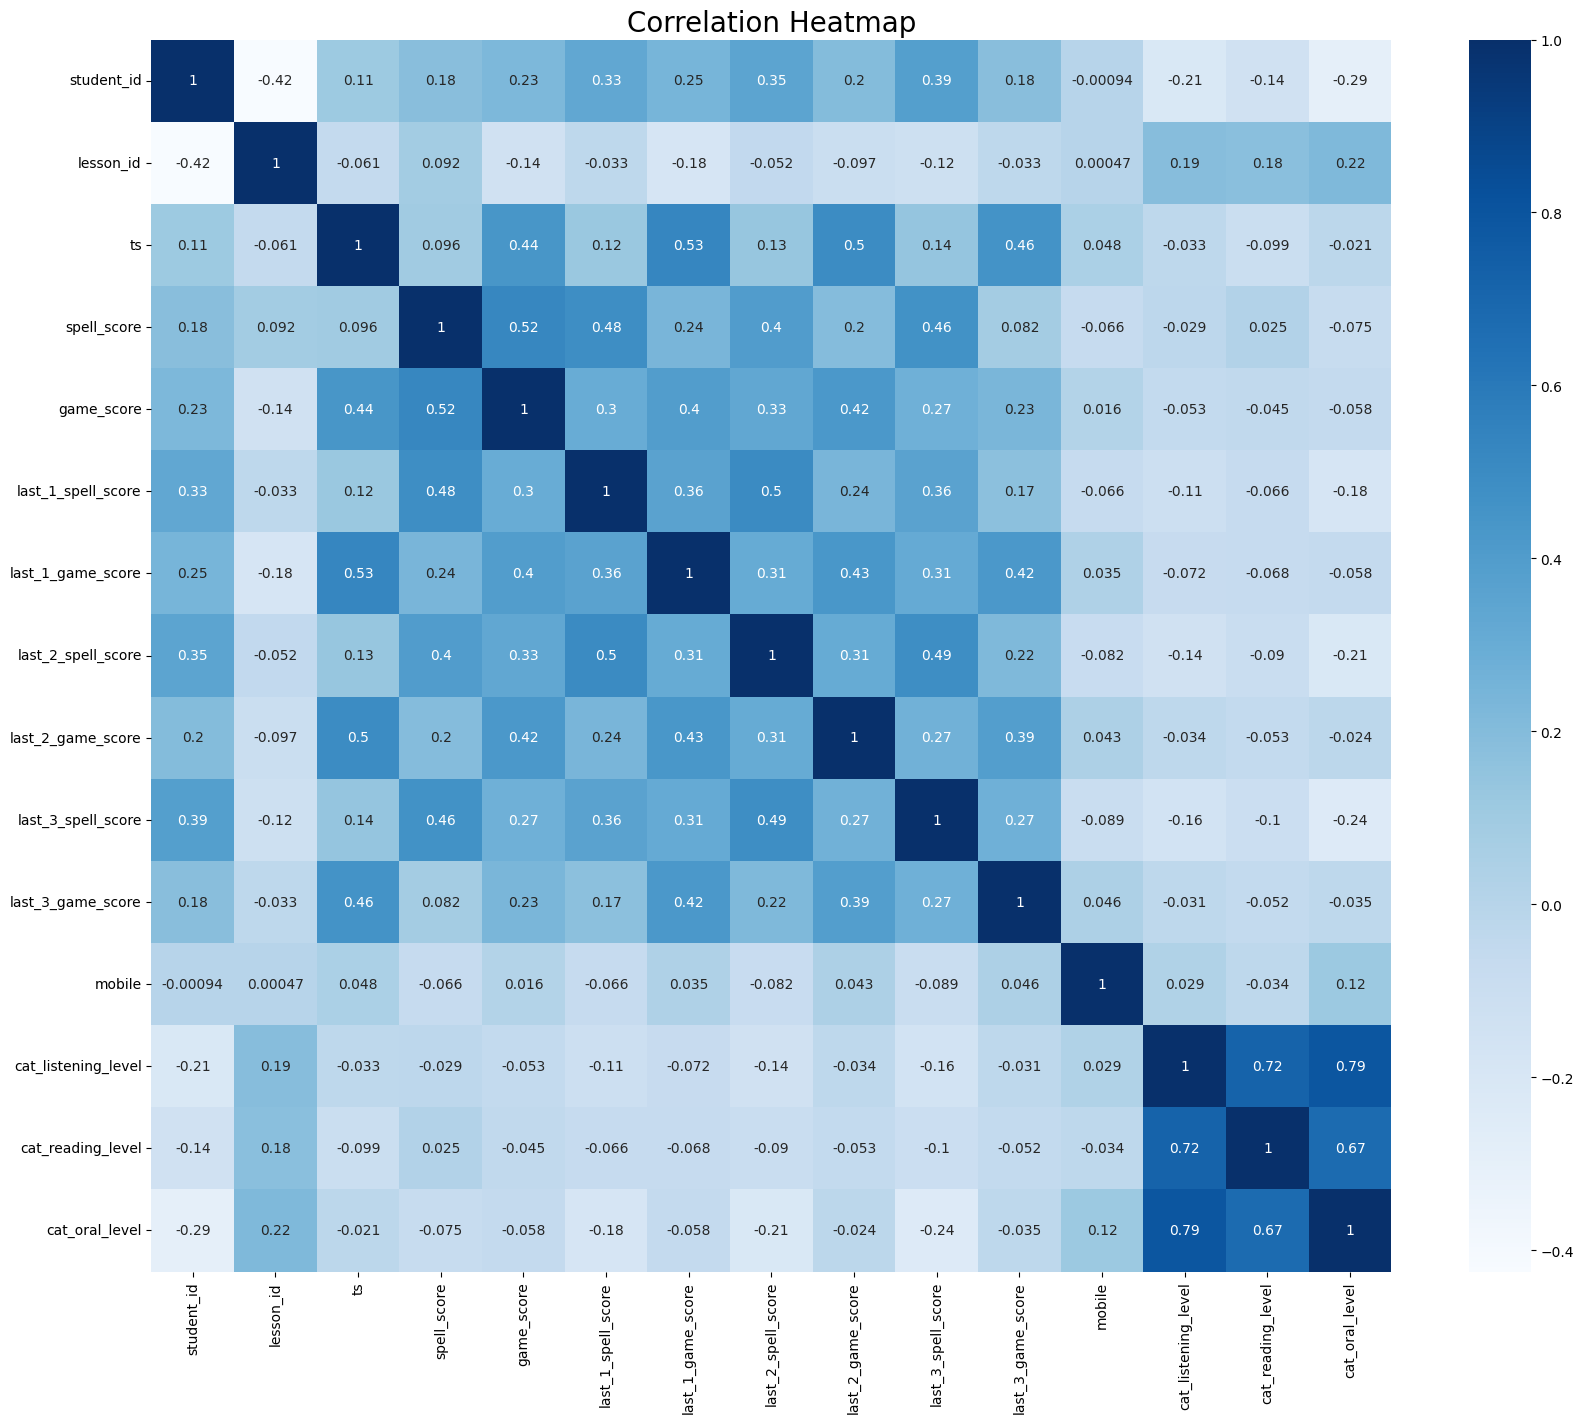

In [13]:
# Calculate the correlation matrix
# 排除非数值型字段（如手机号、昵称等），避免相关性计算报错
corr = df.select_dtypes(include=[np.number]).corr()

# Create a figure with a large size
# plt.figure(figsize=(50,50))
plt.figure(figsize=(20, 16))  # 调整为更合适的大小

# Plot the heatmap using seaborn, with annotations and a blue colormap
sns.heatmap(corr, annot=True, cmap="Blues")

# Set the title of the plot
plt.title('Correlation Heatmap', fontsize=20)

## sex-score 字段

Boy: 352
Girl: 1215


Text(0.5, 1.0, 'Count of Sex')

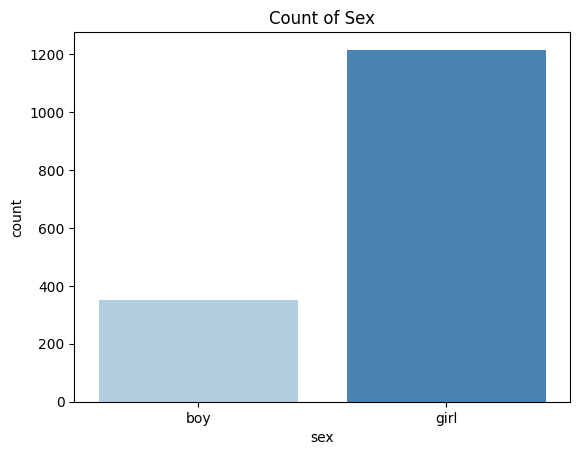

In [14]:
# # Ignore warnings
# warnings.filterwarnings("ignore")

# Count the occurrences of each category in the 'sex' column
target_count = df.sex.value_counts()

# Print the count of males
print('Boy:', target_count[1])

# Print the count of females
print('Girl:', target_count[0])

# Create a count plot of 'sex' with seaborn
sns.countplot(data=df, x="sex", hue="sex", palette="Blues")

# Set the title of the plot
plt.title('Count of Sex') 


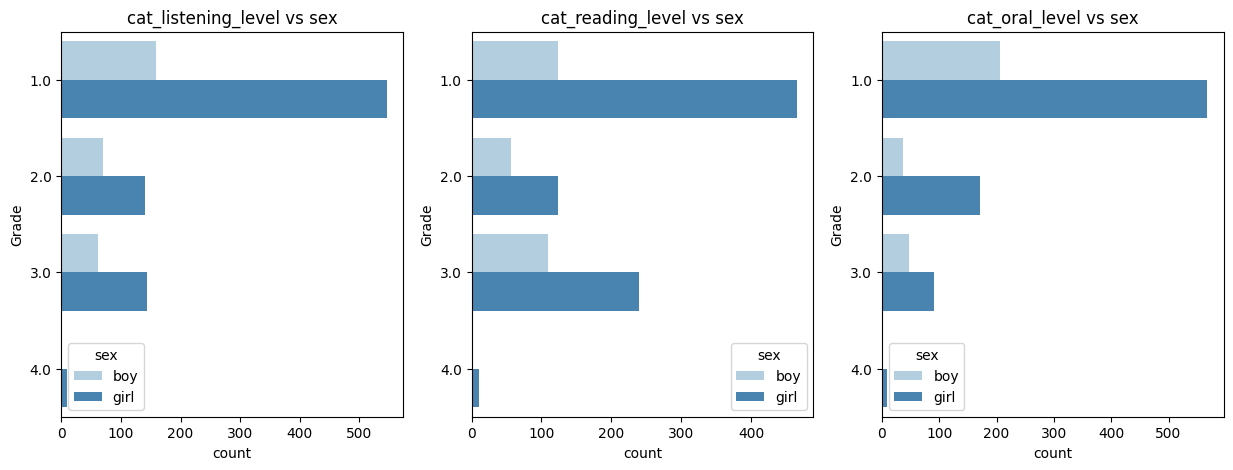

In [15]:
# 创建1行3列子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

# 遍历三个CAT等级字段并绘制
for i, grade_period in enumerate(['cat_listening_level', 'cat_reading_level', 'cat_oral_level']):
    sns.countplot(ax=axes[i], data=df, y=grade_period, hue="sex", palette="Blues")
    axes[i].set_title(f'{grade_period} vs sex')
    axes[i].set_ylabel("Grade")

plt.show()


## student 字段

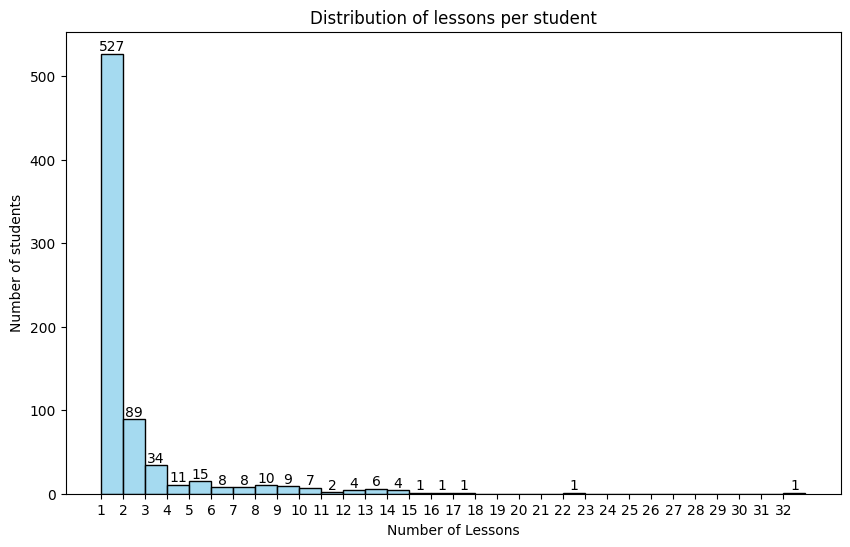

In [16]:
# 统计每个学生有几条数据
student_counts = df['student_id'].value_counts()

# 绘制每个学生上课次数的分布直方图，并在每个柱子上显示人数
plt.figure(figsize=(10,6))
bins = range(1, student_counts.max()+2)
ax = sns.histplot(student_counts, bins=bins, kde=False, color='skyblue')
plt.xlabel('Number of Lessons')
plt.ylabel('Number of students')
plt.title('Distribution of lessons per student')

plt.xticks(range(1, student_counts.max()+1))

# 在每个柱子上显示人数
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(str(height), 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10)

plt.show()


## score 字段

                    null  zero  negative  other
spell_score            0   242         0   1325
game_score             0   595         0    972
last_1_spell_score   739    68         0    760
last_1_game_score    739   340         0    488
last_2_spell_score   951    52         0    564
last_2_game_score    951   296         0    320
last_3_spell_score  1074    47         0    446
last_3_game_score   1074   261         0    232


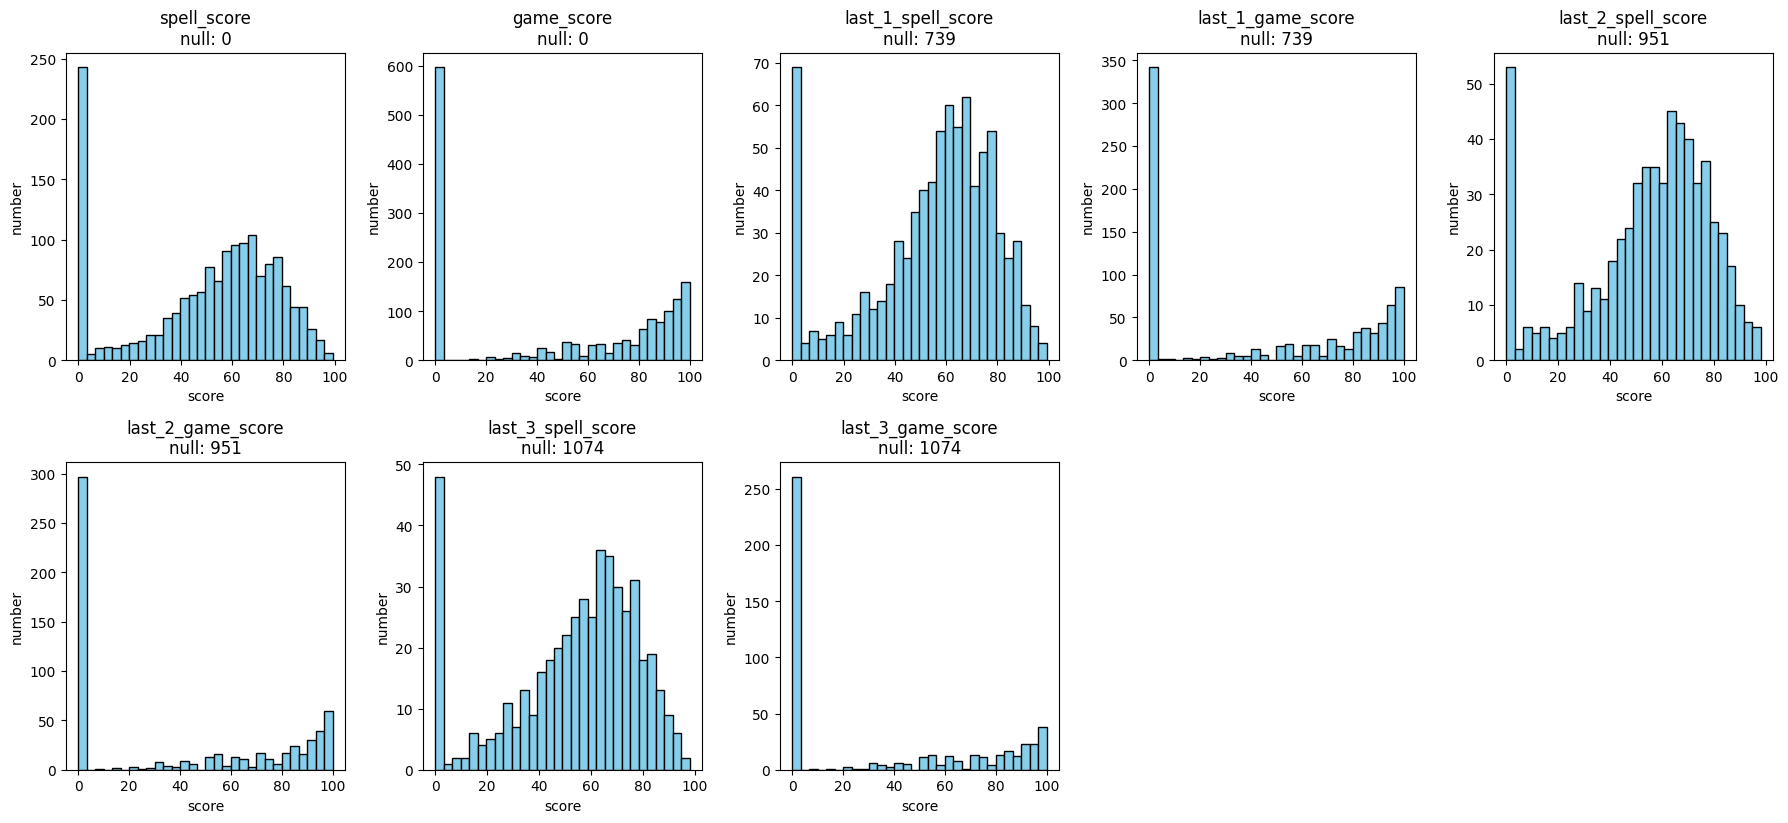

In [17]:
# 统计所有以score结尾的字段的null、0、负数和其他的数量
score_cols = [col for col in df.columns if col.endswith('score')]

result = {}

for col in score_cols:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    other_count = df.shape[0] - null_count - zero_count - negative_count
    result[col] = {
        'null': null_count,
        'zero': zero_count,
        'negative': negative_count,
        'other': other_count
    }

# 返回统计结果的表格
import pandas as pd
result_df = pd.DataFrame(result).T
print(result_df)

# 画出每个以score结尾的字段的直方图，并单独统计null数量
import matplotlib.pyplot as plt

score_cols = [col for col in df.columns if col.endswith('score')]

plt.figure(figsize=(18, 12))
for i, col in enumerate(score_cols):
    plt.subplot(3, 5, i+1)
    data = df[col]
    data_non_null = data.dropna()
    null_count = data.isnull().sum()
    plt.hist(data_non_null, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{col}\nnull: {null_count}")
    plt.xlabel('score')
    plt.ylabel('number')
plt.tight_layout()
plt.show()


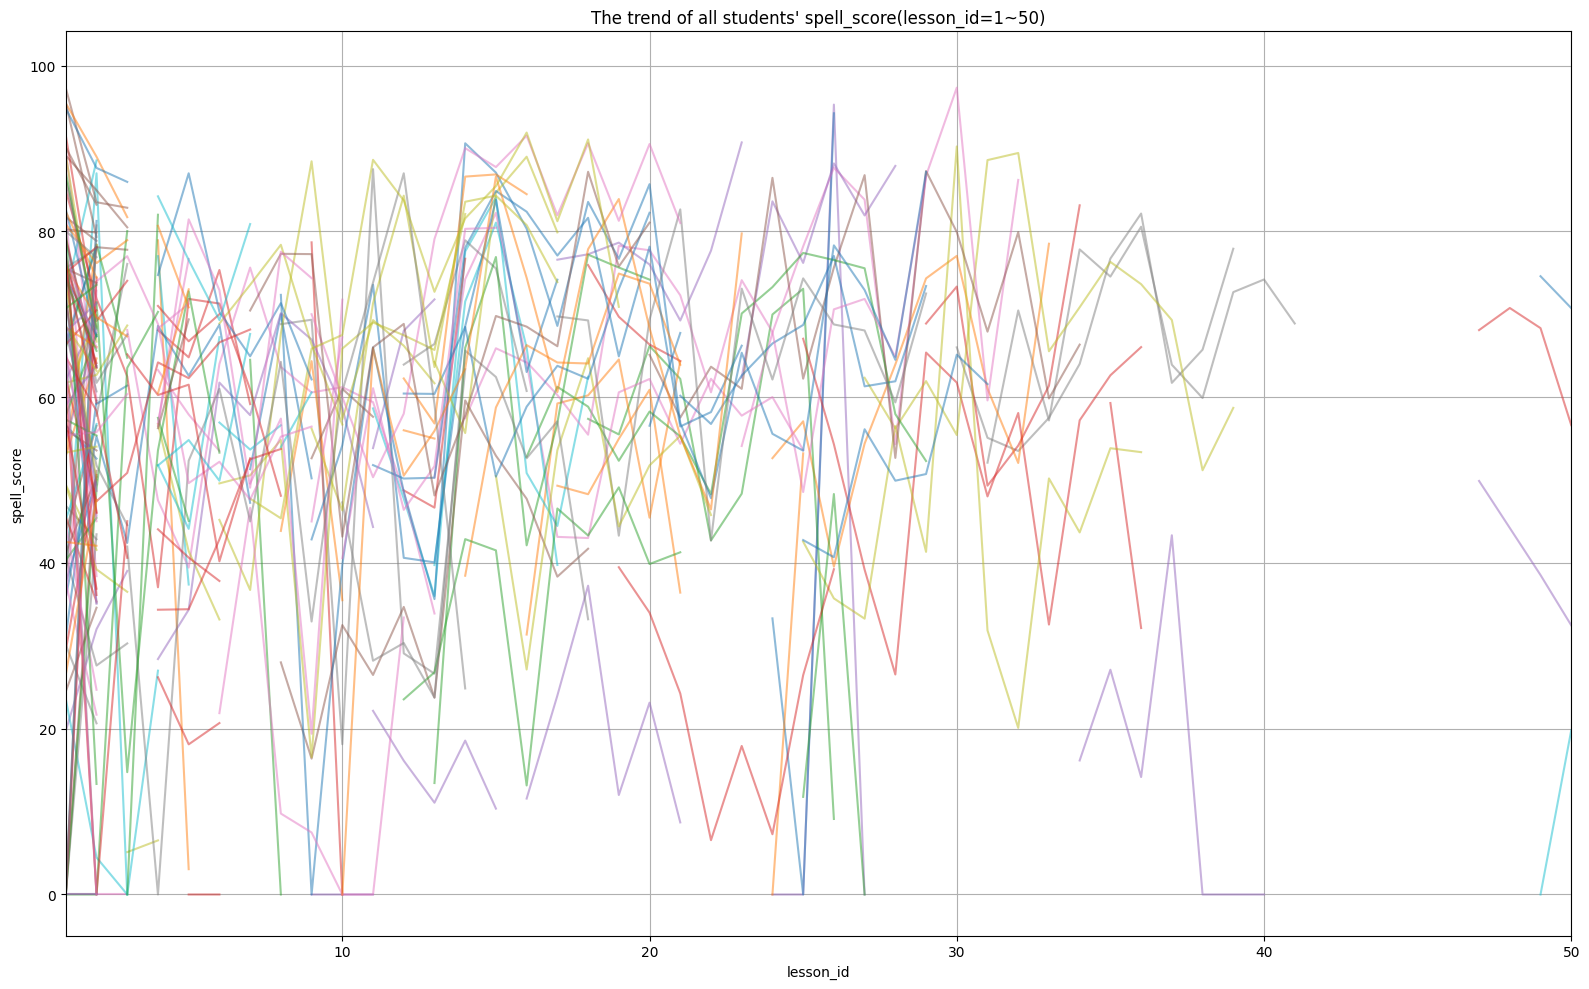

In [18]:
# 统计每个学生的spell_score走势，横坐标是lesson_id，纵坐标是score，把所有学生的走势画在一张图里

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 10))

# 固定lesson_id为1~50，作为横坐标
lesson_ids = np.arange(1, 51)

# 检查lesson_id列的数据类型，确保可以比较和转换为int
if df['lesson_id'].dtype != np.int64 and df['lesson_id'].dtype != np.int32:
    df['lesson_id'] = pd.to_numeric(df['lesson_id'], errors='coerce')

# 检查spell_score列的数据类型，确保可以为数值型
if df['spell_score'].dtype not in [np.float64, np.float32, np.int64, np.int32]:
    df['spell_score'] = pd.to_numeric(df['spell_score'], errors='coerce')

# 按student_id分组
for student_id, group in df.groupby('student_id'):
    # 构建长度为50的spell_score数组，缺失的lesson_id用np.nan填充
    spell_scores = np.full(50, np.nan)
    # 只取lesson_id在1~50范围内的数据
    valid_group = group[(group['lesson_id'] >= 1) & (group['lesson_id'] <= 50)]
    # lesson_id需要减1作为索引
    lesson_idx = valid_group['lesson_id'].astype(int) - 1
    spell_scores[lesson_idx] = valid_group['spell_score'].values
    plt.plot(lesson_ids, spell_scores, alpha=0.5)

plt.xlabel('lesson_id')
plt.ylabel('spell_score')
plt.title('The trend of all students\' spell_score(lesson_id=1~50)')
plt.xlim(1, 50)
plt.grid(True)
plt.tight_layout()
plt.show()


# Data Preprocessing

## filter data

- XXX_score 为 null 或 0，表示成绩无效，忽略该条数据

- last_1_XXX_score 为 null，表示没有历史成绩，无法预测，忽略该条数据

In [19]:
# # 过滤无效数据：XXX_score为null或0，last_1_XXX_score为null的行需要忽略
# score_cols = ['spell_score', 'game_score']
# last_n_cols = [f'last_1_{col}' for col in score_cols]

# # 0.1 过滤主成绩为null或0的行
# for col in score_cols:
#     df = df[~df[col].isna() & (df[col] != 0)]

# # 0.2 过滤last_1_xxx_score为null的行
# for col in last_n_cols:
#     df = df[~df[col].isna()]

# df = df.reset_index(drop=True)

## preprocess data items

- 是否具有last_n成绩：is_valid_last_n

- 倒数第n节课的发音/拼写/游戏成绩：last_n_fa/spell/game_score
  - 如果没有 last_n_xxx_score，使用 last_n-1_xxx_score 填充

- 倒数第n节课的成绩：last_n_grade = last_n_spell_score + last_n_game_score
  - 如果没有last_n，使用 last_n-1 填充

- 年龄：age = now_time - birthday
  - 如果没有birthday，使用平均值填充

- 年龄的平方根：age_sqrt = np.sqrt(age)

- 城市：city_level 使用 one-hot 编码

- 当前课程的对数：lesson_id_log = np.log(lesson_id)

- 是否具有CAT成绩：is_valid_cat

- CAT听/说/读成绩：cat_listening/reading/oral_level
  - 如果没有 cat_listening/reading/oral_level，使用平均值填充

- CAT成绩：cat_grade = cat_listening_level + cat_reading_level + cat_oral_level
  - 如果没有CAT，使用平均值填充



In [20]:
# 预处理数据项

# 1.1 是否具有last_n成绩
for n in [1, 2, 3]:
    df[f'is_valid_last_{n}'] = (~df[f'last_{n}_spell_score'].isna()) & \
                               (~df[f'last_{n}_game_score'].isna())

# 1.2 last_n_xxx_score缺失时用last_n-1_xxx_score填充
for n in [1, 2, 3]:
    for score_type in ['spell_score', 'game_score']:
        col = f'last_{n}_{score_type}'
        if n > 1:
            prev_col = f'last_{n-1}_{score_type}'
            # 用last_n-1_xxx_score填充last_n_xxx_score的缺失
            df[col] = df[col].fillna(df[prev_col])
        else:
            # 用主成绩列xxx_score填充last_1_xxx_score的缺失
            df[col] = df[col].fillna(df[score_type])

# 1.3 倒数第n节课的成绩
for n in [1, 2, 3]:
    # 先直接相加
    df[f'last_{n}_grade'] = df[f'last_{n}_spell_score'].fillna(0) + \
                      df[f'last_{n}_game_score'].fillna(0)
    # 如果last_n为0（说明全是NaN），用last_n-1填充
    if n > 1:
        mask = (df[f'last_{n}_grade'] == 0)
        df.loc[mask, f'last_{n}_grade'] = df.loc[mask, f'last_{n-1}_grade']

# 2.1 年龄
now_time = pd.to_datetime('today')
df['birthday'] = pd.to_datetime(df['birthday'], errors='coerce')
df['age'] = (now_time - df['birthday']).dt.days / 365  # 保留小数
# 用平均年龄填充缺失
mean_age = df['age'].mean()
df['age'] = df['age'].fillna(mean_age)

# 2.2 年龄的平方根
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age_sqrt'] = np.sqrt(df['age'])

# 3.1 当前课程的对数
df['lesson_id'] = pd.to_numeric(df['lesson_id'], errors='coerce')
df['lesson_id_log'] = np.log1p(df['lesson_id'])

# 4.1 是否具有CAT成绩
df['is_valid_cat'] = (~df['cat_listening_level'].isna()) & \
                     (~df['cat_reading_level'].isna()) & \
                     (~df['cat_oral_level'].isna())

# 4.2 用平均值填充cat_listening/reading/oral_level的缺失
for col in ['cat_listening_level', 'cat_reading_level', 'cat_oral_level']:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

# 4.3 CAT成绩，用平均值填充缺失
df['cat_grade'] = df['cat_listening_level'].fillna(df['cat_listening_level'].mean()) + \
                  df['cat_reading_level'].fillna(df['cat_reading_level'].mean()) + \
                  df['cat_oral_level'].fillna(df['cat_oral_level'].mean())

## encode data items

城市

In [21]:
# 创建一个新的DataFrame，包含原数据+OneHot编码列
df = pd.get_dummies(df, columns=['city_id'], prefix='city')

性别

In [22]:
# 参考上面数据内容，只有'sex'和'cat_listening_level'等为类别型，其他多为数值型
from sklearn.preprocessing import LabelEncoder

# 只对'sex'字段做LabelEncoder编码
if 'sex' in df.columns:
    le = LabelEncoder()
    df['sex'] = le.fit_transform(df['sex'])
    print(f"sex编码映射: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    # 例如: {'boy': 0, 'girl': 1}


sex编码映射: {'boy': 0, 'girl': 1}


## visualize and analyze data items

In [23]:
print("📔 Data Info: ")
df.info()

with pd.option_context('display.max_columns', None):
    print("📔 Data Examples: ")
    display(df.head(5))

📔 Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   student_id           1567 non-null   float64       
 1   lesson_id            1567 non-null   float64       
 2   ts                   1567 non-null   float64       
 3   spell_score          1567 non-null   float64       
 4   game_score           1567 non-null   float64       
 5   last_1_spell_score   1567 non-null   float64       
 6   last_1_game_score    1567 non-null   float64       
 7   last_2_spell_score   1567 non-null   float64       
 8   last_2_game_score    1567 non-null   float64       
 9   last_3_spell_score   1567 non-null   float64       
 10  last_3_game_score    1567 non-null   float64       
 11  mobile               1567 non-null   int64         
 12  nickname             1567 non-null   object        
 13  sex                

,student_id,lesson_id,ts,spell_score,game_score,last_1_spell_score,last_1_game_score,last_2_spell_score,last_2_game_score,last_3_spell_score,last_3_game_score,mobile,nickname,sex,birthday,cat_listening_level,cat_reading_level,cat_oral_level,is_valid_last_1,is_valid_last_2,is_valid_last_3,last_1_grade,last_2_grade,last_3_grade,age,age_sqrt,lesson_id_log,is_valid_cat,cat_grade,city_一线,city_三线,city_二线,city_四线,city_新一线,city_空值
0,5611.0,1.0,1.755588e+09,19.750000,26.923077,19.750000,26.923077,19.750000,26.923077,19.75,26.923077,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,False,False,False,46.673077,46.673077,46.673077,7.736986,2.781544,0.693147,True,9.0,True,False,False,False,False,False
1,5611.0,2.0,1.755016e+09,32.000000,57.142857,19.750000,26.923077,19.750000,26.923077,19.75,26.923077,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,False,False,46.673077,46.673077,46.673077,7.736986,2.781544,1.098612,True,9.0,True,False,False,False,False,False
2,5611.0,3.0,1.754564e+09,39.029412,91.666667,32.000000,57.142857,19.750000,26.923077,19.75,26.923077,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,True,False,89.142857,46.673077,46.673077,7.736986,2.781544,1.386294,True,9.0,True,False,False,False,False,False
3,5611.0,5.0,1.757497e+09,0.000000,0.000000,39.029412,91.666667,32.000000,57.142857,19.75,26.923077,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,True,True,130.696078,89.142857,46.673077,7.736986,2.781544,1.791759,True,9.0,True,False,False,False,False,False
4,5611.0,9.0,1.758365e+09,0.000000,0.000000,0.000000,0.000000,39.029412,91.666667,32.00,57.142857,15711199244,157****9244,0,2018-01-01,3.0,3.0,3.0,True,True,True,0.000000,130.696078,89.142857,7.736986,2.781544,2.302585,True,9.0,True,False,False,False,False,False


Text(0.5, 1.0, 'Correlation Heatmap')

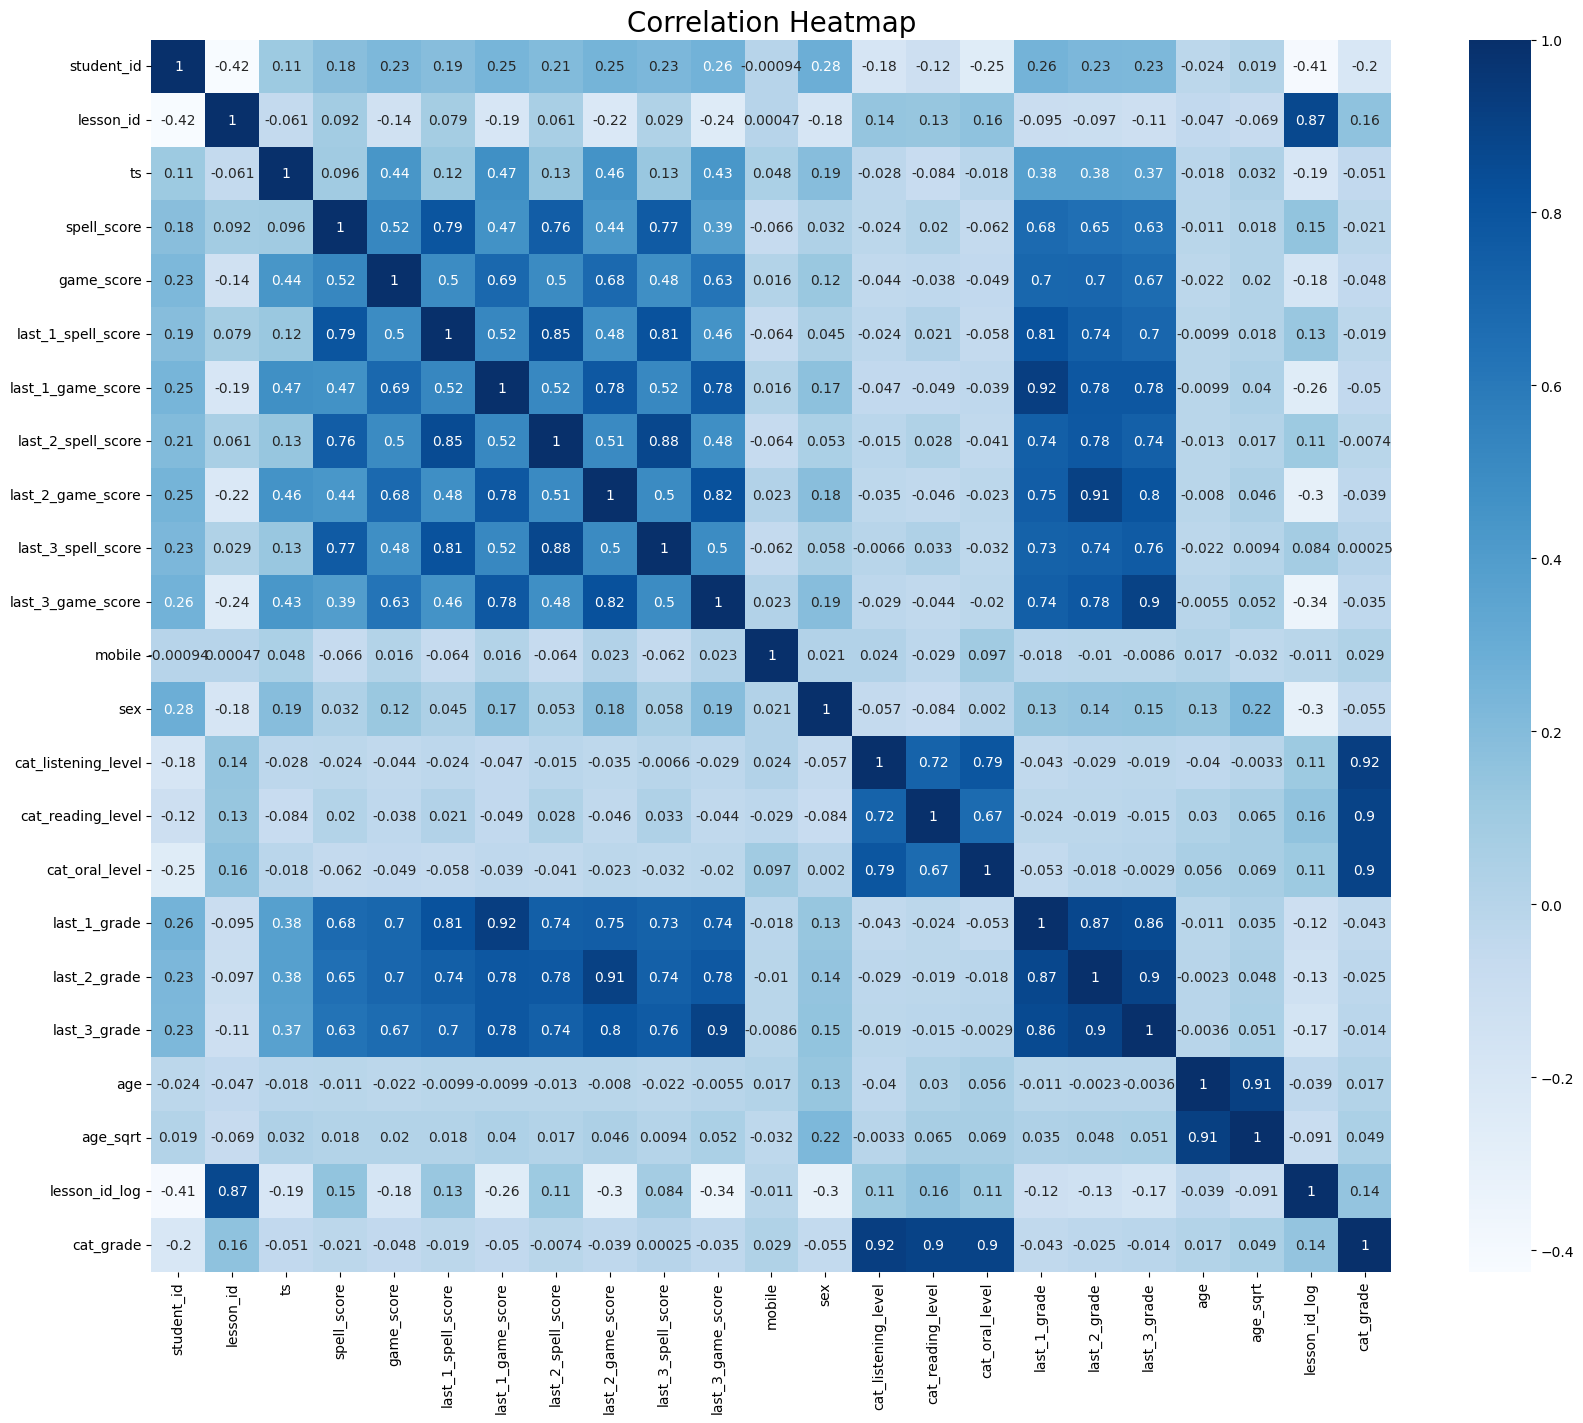

In [24]:
# Calculate the correlation matrix
# 排除非数值型字段（如手机号、昵称等），避免相关性计算报错
corr = df.select_dtypes(include=[np.number]).corr()

# Create a figure with a large size
# plt.figure(figsize=(50,50))
plt.figure(figsize=(20, 16))  # 调整为更合适的大小

# Plot the heatmap using seaborn, with annotations and a blue colormap
sns.heatmap(corr, annot=True, cmap="Blues")

# Set the title of the plot
plt.title('Correlation Heatmap', fontsize=20)


<Axes: xlabel='spell_score'>

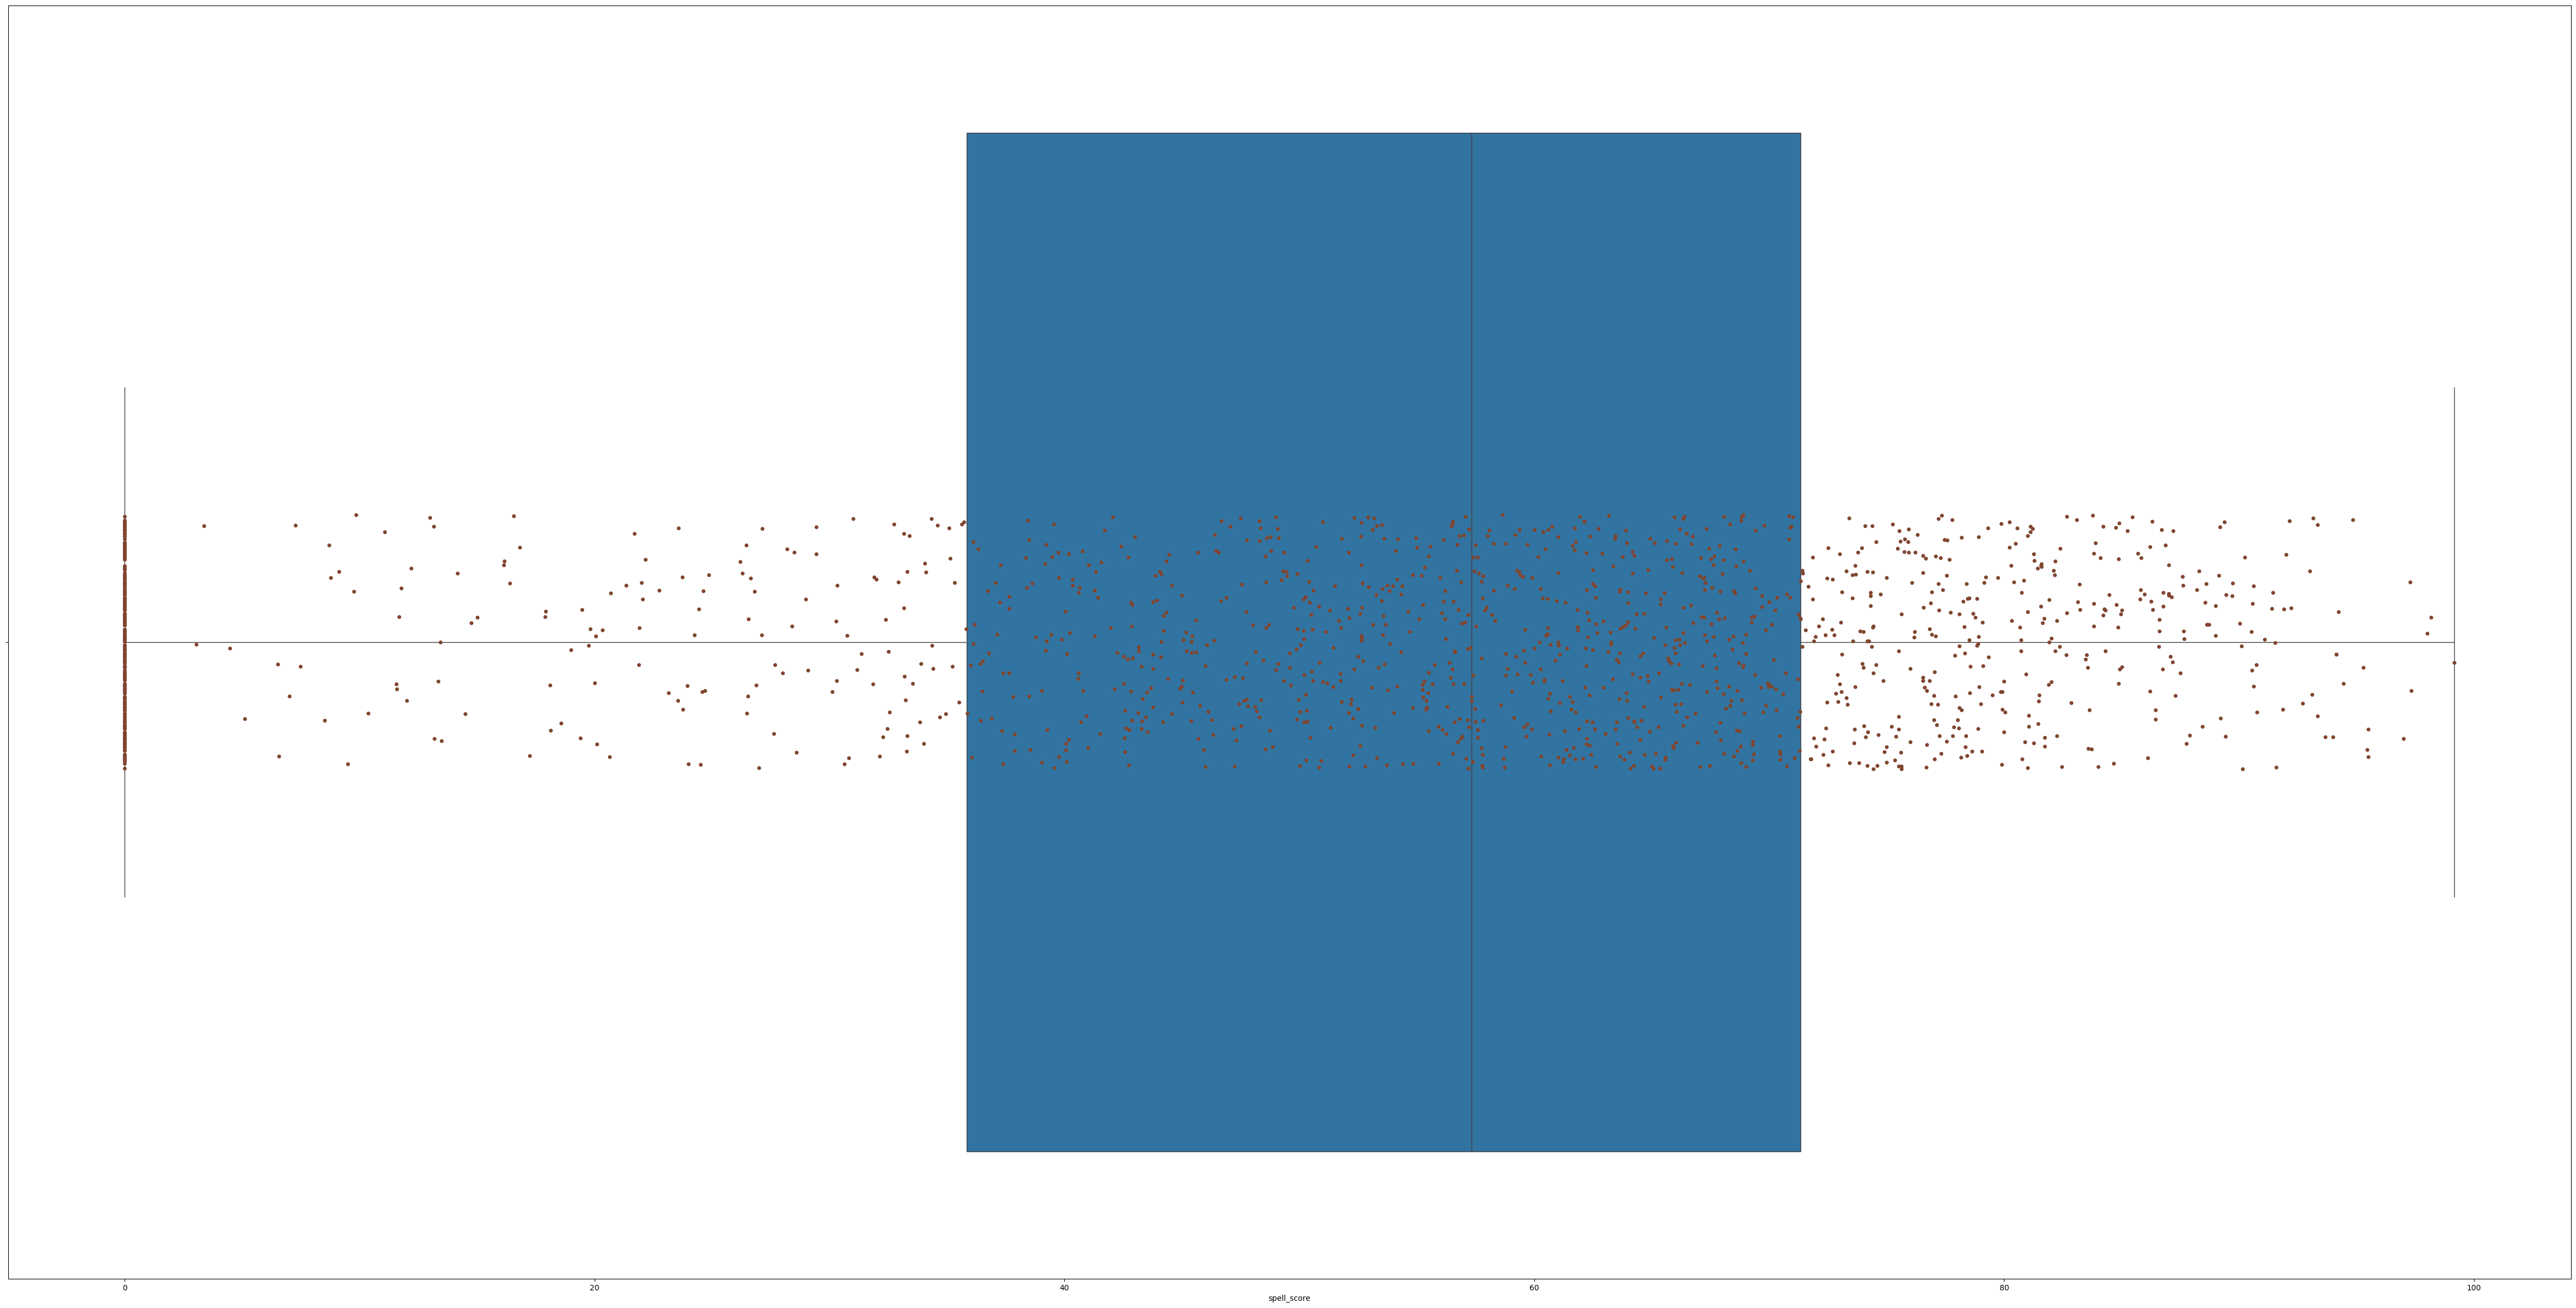

In [25]:
# cheaking the outliers in the feature 'G1'
plt.figure(figsize = (60,30))
sns.boxplot(x='spell_score', data=df)
sns.stripplot(x='spell_score', data=df, color="#804630")

# Feature Selection

In [26]:
feat = [
    'last_1_spell_score', 'last_1_game_score', 'is_valid_last_1', 
    'last_2_spell_score', 'last_2_game_score', 'is_valid_last_2', 
    'last_3_spell_score', 'last_3_game_score', 'is_valid_last_3', 
    'cat_listening_level', 'cat_reading_level', 'cat_oral_level', 'is_valid_cat', 
    'sex', 'age', 'lesson_id' , # 'age_sqrt', 'lesson_id_log'
    'city_一线', 'city_三线', 'city_二线', 'city_四线', 'city_新一线', 'city_空值', 
]

# Model and Optimaization

### Summary

| 模型 | MSE | RMSE | R^2 |
| --- | --- | --- | --- |
| Linear Regression (baseline) | 91 | 9.55 | 0.83 |
| Decision Tree Regression | 84 | 9.15 | 0.85 |
| Random Forest Regression | 74 | 8.62 | 0.86 |
| Support Vector Machine Regression (SVR) | 63 | 7.92 | 0.89 |
| XGBoost Regression | 70 | 8.38 | 0.87 |
| K Nearest Neighbors Regression (KNNR) | 90 | 9.48 | 0.84 |
| MLP (神经网络) | 98 | 9.89 | 0.82 |

- **MSE（均方误差）**：反映预测值与真实值之间的平均平方差，数值越小表示模型预测越准确。
- **RMSE（均方根误差）**：MSE的平方根，和原始数据量纲一致，更直观地衡量预测误差的大小，越小越好。
- **R²（决定系数）**：衡量模型对数据的拟合优度，取值范围0~1，越接近1说明模型解释能力越强。



| 模型                                          | 优点                               | 缺点                           | 在你数据集的适用性                        |
| ------------------------------------------- | -------------------------------- | ---------------------------- | -------------------------------- |
| **Linear Regression**                       | 简单、计算快、结果可解释性强                   | 只能拟合线性关系；缺失值要补齐；容易欠拟合        | **可做Baseline**，快速验证数据质量          |
| **Decision Tree Regression**                | 能处理非线性关系；对缺失值相对不敏感（部分实现支持）；可解释性强 | 容易过拟合，单树泛化能力弱                | 样本小的情况下可用，但结果可能不稳定               |
| **Random Forest Regression**                | 集成学习，稳定性好；能自动评估特征重要性；对缺失值较鲁棒     | 样本太小（150条）时，容易过拟合或不稳定        | 样本太少时效果未必比单棵树好                   |
| **Support Vector Machine Regression (SVR)** | 在小样本场景下常常表现好；能捕捉复杂模式             | 对缺失值敏感；需要特征缩放；参数调优麻烦         | **很适合150条这种小数据集**，但要注意缺失值处理和参数调优 |
| **XGBoost Regression**                      | 表现强大；能处理缺失值（内置机制）；非线性拟合能力强       | 样本太小容易过拟合；参数调优复杂             | 样本量不足时可能不如SVR/树简单                |
| **K Nearest Neighbors Regression (KNNR)**   | 原理简单；能捕捉局部模式                     | 对缺失值非常敏感；维度高、样本少时容易退化；预测时开销大 | **不太适合你的数据（样本小+缺失多）**            |
| **MLP (神经网络)**                              | 能学习复杂非线性关系                       | 样本太少，极易过拟合；缺失值要处理；需要GPU      | **基本不推荐150条数据用MLP**              |


### Linear Regression model

作为 baseline

In [28]:
# Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Linear Regression with specified parameters
LR = LinearRegression(fit_intercept= True ,n_jobs = 1)

# Train the regression
LR.fit(X_train, y_train)

# Predict on the testing data
y_pred = LR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

# MSE：均方误差，衡量预测值与真实值的平均平方差，越小越好
print("LR Mean Squared Error MSE:", mse)
# RMSE：均方根误差，MSE的平方根，和原始数据量纲一致，越小越好
print("LR Root Mean Squared Error RMSE:", rmse)
# R^2：决定系数，衡量模型拟合优度，1为完美拟合，0为无解释力
print("LR R^2 Score:", r2)

LR Mean Squared Error MSE: 250.35861771885317
LR Root Mean Squared Error RMSE: 15.822724724864967
LR R^2 Score: 0.6899004382245002


In [29]:
# using Gridsearch for best performancing Linear Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV

param_grid = {'fit_intercept': [True, False],
              'n_jobs' : [1, -1]}
grid = GridSearchCV(LinearRegression(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

{'fit_intercept': False, 'n_jobs': 1}

In [30]:
grid.best_estimator_

,fit_intercept,False
,copy_X,True
,tol,1e-06
,n_jobs,1
,positive,False


In [31]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized LR Mean Squared Error MSE:", mse)
print("Optimaized LR Root Mean Squared Error RMSE:", rmse)
print("Optimaized LR R^2 Score:", r2)

Optimaized LR Mean Squared Error MSE: 250.3586177188517
Optimaized LR Root Mean Squared Error RMSE: 15.822724724864921
Optimaized LR R^2 Score: 0.689900438224502


In [32]:
# Get the list of available parameters in Linear Regression model
parameters = LinearRegression().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'positive', 'tol'])


### Decision Tree Regression model

In [33]:
# Decision Tree Regression model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regression with specified parameters
DTR = DecisionTreeRegressor(random_state=100, criterion='squared_error', max_depth=30, min_samples_leaf=5)

# Train the regression
DTR.fit(X_train, y_train)

# Predict on the testing data
y_pred = DTR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("DTR Mean Squared Error MSE:", mse)
print("DTR Root Mean Squared Error RMSE:", rmse)
print("DTR R^2 Score:", r2)

DTR Mean Squared Error MSE: 338.7934260811047
DTR Root Mean Squared Error RMSE: 18.406342007066606
DTR R^2 Score: 0.5803631849487589


In [35]:
# using Gridsearch for best performancing Decision Tree Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 31))
param_grid = {'random_state': number,
              'criterion' : ["squared_error", "absolute_error", "friedman_mse", "poisson"],
              'max_depth' : numbers,
              'min_samples_leaf' :  numbers}
grid = GridSearchCV(DecisionTreeRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

KeyboardInterrupt: 

In [ ]:
grid.best_estimator_

,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,27
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized DTR Mean Squared Error MSE:", mse)
print("Optimaized DTR Root Mean Squared Error RMSE:", rmse)
print("Optimaized DTR R^2 Score:", r2)

Optimaized DTR Mean Squared Error MSE: 269.9118000043466
Optimaized DTR Root Mean Squared Error RMSE: 16.428992665539376
Optimaized DTR R^2 Score: 0.6656814466303819


In [ ]:
# Get the list of available parameters in Decision Tree Regression model
parameters = DecisionTreeRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])


### Random Forest Regression model

In [ ]:
# Random Forest Regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Random Forest Regression with specified parameters
RFR = RandomForestRegressor(random_state=100, criterion='squared_error', max_depth=30, min_samples_leaf=5, n_jobs=1)

# Train the regression
RFR.fit(X_train, y_train)

# Predict on the testing data
y_pred = RFR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("RFR Mean Squared Error MSE:", mse)
print("RFR Root Mean Squared Error RMSE:", rmse)
print("RFR R^2 Score:", r2)

RFR Mean Squared Error MSE: 238.66892937216127
RFR Root Mean Squared Error RMSE: 15.448913533713666
RFR R^2 Score: 0.7043795373129609


In [ ]:
# using Gridsearch for best performancing Random Forest Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 31))
param_grid = {'criterion': ["squared_error", "absolute_error"],
              'random_state' : number,
              'n_jobs' : [1, -1],
              'max_depth' :  numbers}
grid = GridSearchCV(RandomForestRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

KeyboardInterrupt: 

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized RFR Mean Squared Error MSE:", mse)
print("Optimaized RFR Root Mean Squared Error RMSE:", rmse)
print("Optimaized RFR R^2 Score:", r2)

In [ ]:
# Get the list of available parameters in Random Forest Regression model
parameters = RandomForestRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

### Support Vector Machine Regression model

In [36]:
# Support Vector Machine Regression model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Support Vector Machine Regression  with specified parameters
SVMR = SVR(kernel ='poly')

# Train the regression
SVMR.fit(X_train, y_train)

# Predict on the testing data
y_pred = SVMR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)


print("SVMR Mean Squared Error MSE:", mse)
print("SVMR Root Mean Squared Error RMSE:", rmse)
print("SVMR R^2 Score:", r2)

SVMR Mean Squared Error MSE: 445.2959608621146
SVMR Root Mean Squared Error RMSE: 21.102036888938343
SVMR R^2 Score: 0.44844685762401326


In [ ]:
# using Gridsearch for best performancing Support Vector Machine Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 11))
param_grid = {'gamma' : ['scale', 'auto'],
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' :  numbers}
grid = GridSearchCV(SVR(),param_grid,refit=True, verbose=3, cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized SVMR Mean Squared Error MSE:", mse)
print("Optimaized SVMR Root Mean Squared Error RMSE:", rmse)
print("Optimaized SVMR R^2 Score:", r2)

In [ ]:
# Get the list of available parameters in Support Vector Machine Regression model
parameters = SVR().get_params().keys()

# Print the list of available parameters
print(parameters)

### XGBoost Regression model

In [ ]:
# XGBoost Regression model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the XGBoost Regression with specified parameters
XGBR = XGBRegressor(gamma= 0.3, random_state= 42, n_estimators=11, n_jobs= -1, max_depth=10)

# Train the regression
XGBR.fit(X_train, y_train)

# Predict on the testing data
y_pred = XGBR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("XGBR Mean Squared Error MSE:", mse)
print("XGBR Root Mean Squared Error RMSE:", rmse)
print("XGBR R^2 Score:", r2)

In [ ]:
# using Gridsearch for best performancing XGBoost Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 11))
param_grid = {'random_state' : number,
              'n_estimators' : numbers,
              'n_jobs' :  [1, -1],
              'max_depth': numbers}
param_grid = {
    'n_estimators': [8, 10, 11, 12, 15, 20],        # 围绕初始最优值11搜索
    'max_depth': [8, 9, 10, 11, 12],                # 围绕初始最优值10搜索  
    'learning_rate': [0.1, 0.2, 0.3, 0.4],        
    'gamma': [0.2, 0.3, 0.4, 0.5],                  # 围绕初始有效值0.3搜索
    'random_state': number,                         # 固定随机种子，不作为优化目标
    'n_jobs': [-1]                                  # 固定多线程，不作为优化目标
}
grid = GridSearchCV(XGBRegressor(), param_grid, cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized XGBR Mean Squared Error MSE:", mse)
print("Optimaized XGBR Root Mean Squared Error RMSE:", rmse)
print("Optimaized XGBR R^2 Score:", r2)

In [ ]:
# Get the list of available parameters in XGBoost Regression model
parameters = XGBRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

### K Nearest Neighbors Regression model


In [ ]:
# K Nearest Neighbors Regression model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the K Nearest Neighbors Regression model with specified parameters
KNNR = KNeighborsRegressor(n_neighbors= 7, n_jobs= 1, metric= 'manhattan')

# Train the regression
KNNR.fit(X_train, y_train)

# Predict on the testing data
y_pred = KNNR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("KNNR Mean Squared Error MSE:", mse)
print("KNNR Root Mean Squared Error RMSE:", rmse)
print("KNNR R^2 Score:", r2)

In [ ]:
# using Gridsearch for best performancing K Nearest Neighbors Regression model (OPTIMAIZATION)
from sklearn.model_selection import GridSearchCV
number = [5,11,13,41,42,101]
numbers = list(range(1, 51))
param_grid = {'n_neighbors': number,
              'n_jobs' :  [1, -1],
              'metric' : ['manhattan','euclidean','minkowski']}
grid = GridSearchCV(KNeighborsRegressor(),param_grid,cv = 5)
grid.fit(X_train,y_train)
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test)

mse = mean_squared_error(y_test, grid_predictions)

rmse = sqrt(mse)

r2 = r2_score(y_test, grid_predictions)

print("Optimaized KNNR Mean Squared Error MSE:", mse)
print("Optimaized KNNR Root Mean Squared Error RMSE:", rmse)
print("Optimaized KNNR R^2 Score:", r2)

In [ ]:
# Get the list of available parameters in K Nearest Neighbors Regression model
parameters = KNeighborsRegressor().get_params().keys()

# Print the list of available parameters
print(parameters)

### MLP —— MultiLayer Perceptron

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
# 使用DataLoader实现小批次训练
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# 1. 预处理数据
# Separate features and target variable
features = df[feat]  # Features
target = df['spell_score']  # Target variable

X = features.values
y = target.values

# 标准化特征
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# 转为Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 2. 定义改进的MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # 第一隐藏层：适度增加神经元数量
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),      # 批归一化稳定训练
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Dropout防止过拟合
            
            # 第二隐藏层
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),        # LeakyReLU避免死神经元
            nn.Dropout(dropout_rate),
            
            # 第三隐藏层
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2), # 递减Dropout率
            
            # 输出层
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])

# 3. 训练模型
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 400

# 构建TensorDataset
train_dataset = TensorDataset(X_train, y_train)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("开始训练PyTorch MLP模型...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    # 使用DataLoader进行小批次训练
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # 计算平均损失
    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("训练完成！")

# 4. 测试集评估
model.eval()
with torch.no_grad():
    pred = model(X_test)
    test_loss = criterion(pred, y_test)
    print(f"Test MSE: {test_loss.item():.4f}")

# 4. 测试集评估
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    
    # 转换回numpy并反标准化
    y_pred_scaled = y_pred_tensor.numpy().flatten()
    y_test_scaled = y_test.numpy().flatten()
    
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# 计算评估指标
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

print("\n=== PyTorch MLP 模型评估结果 ===")
print("MLPR Mean Squared Error MSE:", mse)
print("MLPR Root Mean Squared Error RMSE:", rmse)
print("MLPR R^2 Score:", r2)


开始训练PyTorch MLP模型...
Epoch 50/400, Loss: 0.3236
Epoch 100/400, Loss: 0.3137
Epoch 150/400, Loss: 0.2627
Epoch 200/400, Loss: 0.2725
Epoch 250/400, Loss: 0.2547
Epoch 300/400, Loss: 0.2426
Epoch 350/400, Loss: 0.2062
Epoch 400/400, Loss: 0.2118
训练完成！
Test MSE: 0.3672

=== PyTorch MLP 模型评估结果 ===
MLPR Mean Squared Error MSE: 284.9377136230469
MLPR Root Mean Squared Error RMSE: 16.880098152056075
MLPR R^2 Score: 0.647070050239563
